In [1]:
import copy
import gc
import json 
import math 

from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import disable_interactive_logging, enable_interactive_logging, is_interactive_logging_enabled

from src.kitchenware_helper import (
    get_latest_version,
    get_labels_for_version,
    get_params_for_version,
    load_history_version,
    plot_accuracy_for_version,
    plot_multiple_versions,
    predict_test_set,
    prepare_kaggle_submission,
    print_false_preds,
    track_experiment,
)

## Load train data
First, we will load the training dataframe and split it into train and validation

In [2]:
# load labels
df_train_full = pd.read_csv('data/train.csv', dtype={'Id': str})
df_train_full['filename'] = 'data/images/' + df_train_full['Id'] + '.jpg'

## EfficientNetV2L Model

The EfficientNetV2 architecture is based on current research from [Tan & Le 2021](https://arxiv.org/abs/2104.00298) and promises faster training speed and less model parameters.

Notes: 
* EfficientNetV2 doesn't need external image preprocessing, because rescaling is part of the model as `Rescale` layer and will rescale pixel to values in the range of [-1, 1].

The following function `train_efficientnet_v2_l()` is a wrapper around the model, to be able to inject different hyperparameters for grid search and save the training histories in an external file.


In [3]:
def train_efficientnet_v2_l(df: pd.DataFrame, epochs: int, params: dict, verbose: bool = False) -> pd.DataFrame:
    """Trains a model based on EfficientNetV2L.
    
    :param pd.DataFrame df: DataFrame with image data for training.
    :param int epochs: Number of epochs the model should train.
    :param dict params: Hyper-parameters the model training should bebased on.

    Returns a DataFrame with the training history.
    """

    # control printing
    if verbose:
        enable_interactive_logging()
    else:
        disable_interactive_logging()

    # new version / id number for experiment tracking
    version: int = get_latest_version() + 1
    
    # train / val split
    # split into 80% train and 20% validation
    #val_cutoff = int(len(df) * 0.8)
    #df_train = df[:val_cutoff]
    #df_val = df[val_cutoff:]
    

    # image augmentation
    image_size = params.get('image_size')

    datagen_augmentation = ImageDataGenerator(
        validation_split = 0.2,
        **params.get('augmentation', {})
    )

    train_generator = datagen_augmentation.flow_from_dataframe(
        df,
        x_col='filename',
        y_col='label',
        target_size=image_size,
        batch_size=32,
        subset='training'
    )

    val_generator = datagen_augmentation.flow_from_dataframe(
        df,
        x_col='filename',
        y_col='label',
        target_size=image_size,
        batch_size=32,
        subset='validation'
    )

    labels = list(train_generator.class_indices.keys())

    # base model
    input_shape = image_size + (3, )

    base_model = EfficientNetV2L(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape, # default 299, 299, 3
        pooling=params.get('model').get('pooling', None),
        include_preprocessing=True
    )
    base_model.trainable = False
    
    # dense layers
    inputs = Input(shape=input_shape)
    layers = base_model(inputs, training=False)

    if params.get('model').get('dense', 0) > 0:
        layers = Dense(params.get('model').get('dense', 0), activation='relu')(layers)
    
    if params.get('model').get('bn', False):
        layers = BatchNormalization()(layers)
    
    if params.get('model').get('dropout', 0) > 0:
        layers = Dropout(params.get('model').get('dropout', 0))(layers)

    outputs = Dense(6)(layers)

    model = Model(inputs, outputs)

    if is_interactive_logging_enabled():
        print(model.summary())

    # compile model
    optimizer = Adam(learning_rate=params.get('training').get('lr', 0.001))
    loss = CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


    # model training
    checkpoint = ModelCheckpoint(
        'models/efficientnetv2l_v%d_{epoch:02d}_{val_accuracy:.4f}.h5' % (version),
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        initial_value_threshold=0.9 # save only models which have more than 90% validation accuracy.
    )

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[checkpoint],
        #initial_epoch = 0
    )

    # free memory immediatly
    del model
    gc.collect()

    track_experiment(
        history, 
        architecture='EfficientNetV2L',
        version=version,
        hyper_params=params,
        labels=labels
    )

    # reenable Keras output
    if verbose is False:
        enable_interactive_logging()

    return version

## Training

We define base parameters for the training, which we will modify in each training iteration.

* `image_size` holds the image size which should be used for the training. After we have found the best combinations of hyper parameters, we could increase the image size for the final training.
* `augmentation` has image augmentation parameters for `keras.preprocessing.image.ImageDataGenerator` based on the hypotheses on data augmentation made in [01 Data Understanding](01-data-understanding.ipynb).
* `model` holds parameters to manipulate the dense layer architeture:
    * `pooling`: Either `max` (=GlobalMaxPooling2D layer), `avg` (=GlobalAveragePooling2D layer) or `None` (=Flatten layer).
    * `dense`: Sets dimensions of the inner dense layer. If 0, no inner dense layer is used.
    * `bn`: If `True` inserts an BatchNormalization layer after the dense layer.
    * `dropout`: Applies a dropout before the output layer. PArameter is the dropout rate between [0.0, 1.0]. If 0, no dropout layer is used.
* `training`: 
    * `lr`: Learning rate used for the training.

In [4]:
base_params = {
    'image_size': (150, 150),
    
    'augmentation': {
        'horizontal_flip': True, 
        'vertical_flip': True,
        'rotation_range': 90, 
        'fill_mode': 'nearest',
        'brightness_range': [0.4,1.5]
    },
    
    'model': {
        'pooling': 'max',
        'dense': 64,
        'bn': True,
        'dropout': 0.5
    },

    'training': {
        'lr': 0.001,
    }
    
}

## Dense Layers Architecture

The architecture of the dense layers, which are used on top of the EfficientNetV2 convolutional layers, is:
1. inner dense layer
2. batch normalization layer
3. dropout layer
4. output dense layer

![Preview of the Model Architecture](images/model-architecture.png "Model Architecture")

The aim of this section is to experiment with the batch normalization and dropout layer.

### Option 1: BatchNormalization Layer

Here we are using a BatchNormalization layer after the inner dense layer witout dropout.

Results:
* Training time: 14 minutes für 20 epochs.
* Approaches 100% training accuracy within 20 epochs, which is a clear sign of extreme overfitting.

In [5]:
# only BatchNormalization, no Dropout
params_v5 = copy.deepcopy(base_params)
params_v5['model']['bn'] = True
params_v5['model']['dropout'] = 0
params_v5['augmentation'] = {} # no image augmentation

In [6]:
training_id = train_efficientnet_v2_l(df_train_full, epochs=20, params=params_v5)

In [6]:
print('Training ID:', training_id)

Training ID: 5


### Option 2: Dropout Layer

Here we are using a Dropout layer with a dropout rate of 0.5 after the inner dense layer without batch normalization.

Results:
* Training time: 15 minutes für 20 epochs.
* No overfitting after 20 epochs.

In [7]:
# only Dropout, no BatchNormalization
params_v6 = copy.deepcopy(base_params)
params_v6['model']['bn'] = False
params_v6['model']['dropout'] = 0.5
params_v6['augmentation'] = {} # no augmentation

In [8]:
training_id = train_efficientnet_v2_l(df_train_full, epochs=20, params=params_v6)

In [7]:
print('Training ID:', training_id)

Training ID: 6


### Option 3: BatchNormalization and Dropout Layer

Here we are using a BatchNormalization layer followed by a Dropout layer with a dropout rate of 0.5.
 
Results:
* Training time: 16 minutes für 20 epochs.
* overfitting

In [9]:
params_v7 = copy.deepcopy(base_params)
params_v7['model']['bn'] = True
params_v7['model']['dropout'] = 0.5
params_v7['augmentation'] = {} # no augmentation

In [10]:
training_id = train_efficientnet_v2_l(df_train_full, epochs=20, params=params_v7)

In [8]:
print('Training ID:', training_id)

Training ID: 7


### Compare Results

Having trained for only 20 epochs without image augmentation, both architecture options with BatchNormalization lead to overfitting. The combination of BatchNormalization and a dropout rate of 0.5 lowers the overfitting slightly, which is confirming the intution of how dropout is working (reduce overfitting). 

In the next section we will introduce image augmentation as an strategy to conquer overfitting. Without using image augmentation, the option without BatchNormalization seems to be favourable.

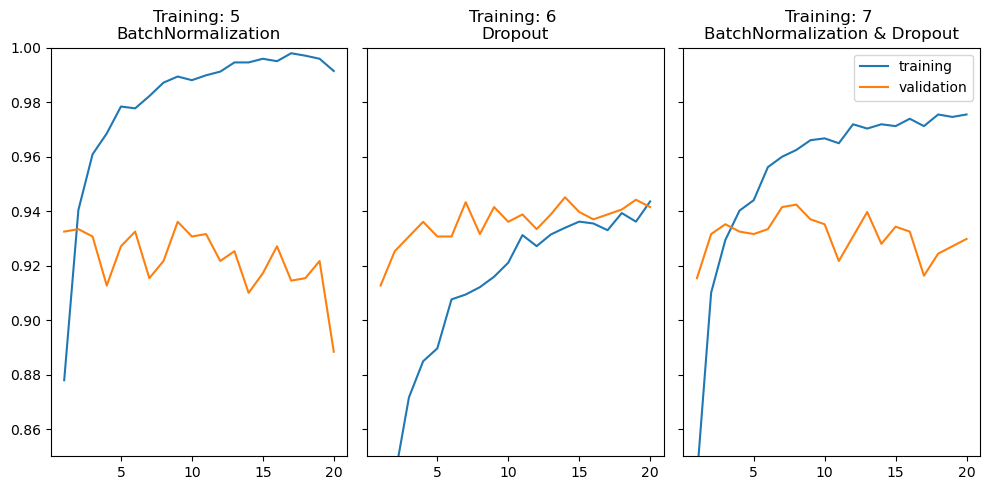

In [4]:
plot_multiple_versions(
    versions=[5, 6, 7],
    titles=['BatchNormalization', 'Dropout', 'BatchNormalization & Dropout'],
    y_lim=(0.85, 1)
)

## Image Augmentation

Image augmenation alters the training images for each epoch slightly, and therefore the CNN is not learning the exact same images on every epoch. 

Not every type of image modification is suitable for each dataset. It depends on the specific contents of the images. The analysis, which image augmentation options might be suitable for the dataset, could be found in the notebook [`01-data-understanding.ipynb`](01-data-understanding.ipynb).

### No Image Augmentation (baseline)

The model is trained without image augmentation.

* Training time: 37 minutes für 50 epochs.
* Kaggle competition score: 0.92041

> Note: The model is overfitting

In [ ]:
# model without augmentation
params_v1 = copy.deepcopy(base_params)
params_v1['augmentation'] = {} # no augmentation

In [ ]:
training_id = train_efficientnet_v2_l(df_train_full, epochs=50, params=params_v1)

In [9]:
print('Training ID:', training_id)

Training ID: 1


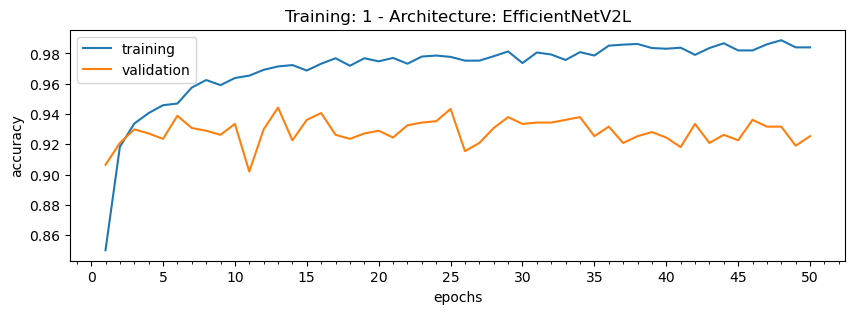

In [10]:
plot_accuracy_for_version(version=1)

The model without image augmentation is clearly overfitting. The model is learning the training data in too much detail and lacked on generalizability. The validation score remains around 0.92, which is also confirmed by the Kaggle competition score of 0.92041.

### Training with Image Augmentation (flip, rotation, brightness)

The model is trained with the following image augmentation options:
* horizontal flip
* vertical flip
* rotation
* brightness

Results:
* Training time: 54 minutes für 50 epochs.
* Kaggle competition score: 0.92816

> Note: The model is sligthly underfitting.

In [ ]:
# model with augmentation
params_v2 = copy.deepcopy(base_params)

In [ ]:
training_id = train_efficientnet_v2_l(df_train_full, epochs=50, params=params_v2)

In [11]:
print('Training ID:', training_id)

Training ID: 2


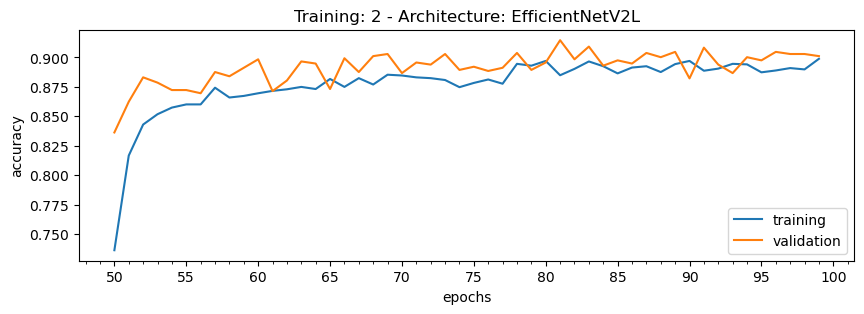

In [ ]:
plot_accuracy_for_version(version=2)

### Training with Image Augmentation (flip and rotation)

The model is trained with the following image augmentation options:
* horizontal flip
* vertical flip
* rotation

Results:
* Training time: 45 minutes für 50 epochs.
* Kaggle competition score: 0.92971

In [ ]:
# model with augmentation
params_v3 = copy.deepcopy(base_params)
del params_v3['augmentation']['brightness_range']

In [ ]:
training_id = train_efficientnet_v2_l(df_train_full, epochs=50, params=params_v3)

In [28]:
print('Training ID:', training_id)

Training ID: 3


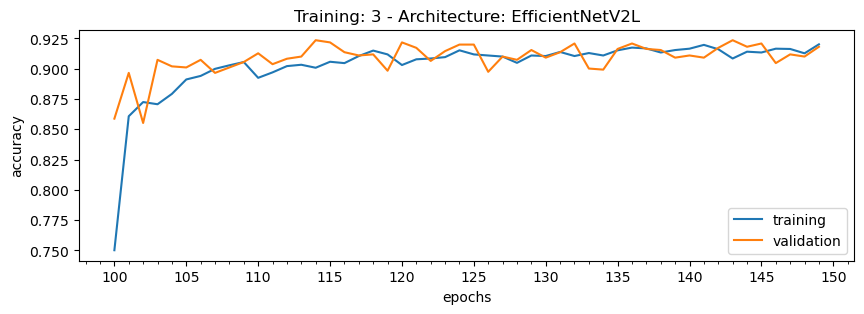

In [ ]:
plot_accuracy_for_version(version=3)

### Training with Image Augmentation (flip)

The model is trained with the following image augmentation options:
* horizontal flip
* vertical flip

Results:
* Training time: 35 minutes für 50 epochs.
* Kaggle competition score: 0.93074

> Note: The model is overfitting.

In [ ]:
params_v4 = copy.deepcopy(base_params)
del params_v4['augmentation']['brightness_range']
del params_v4['augmentation']['rotation_range']

In [ ]:
training_id = train_efficientnet_v2_l(df_train_full, epochs=50, params=params_v4)

In [29]:
print('Training ID:', training_id)

Training ID: 4


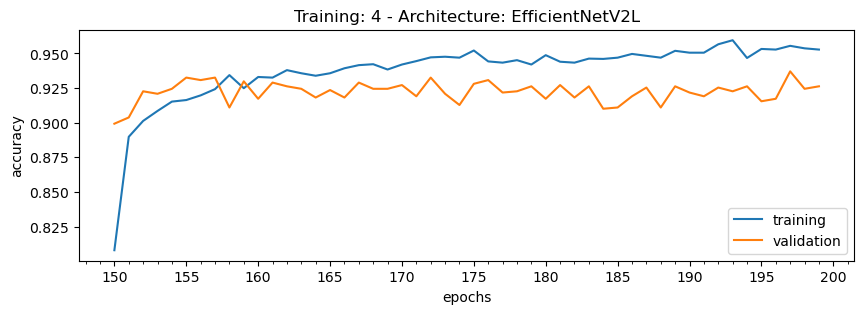

In [ ]:
plot_accuracy_for_version(version=4)

### Compare Image Augmentation results

| **Training ID:**             | 4                   | 3            | 2                        |
| ---------------------------- | ------------------- | ------------ | ------------------------ |
| **Augmentation Parameters:** | flip                | flip, rotate | flip, rotate, brightness |
| **Training Time:**           | 00:34:52            | 00:45:28     | 00:53:46                 |
| **Best Epoch:**              | 48                  | 15           | 32                       |
| **Training Accuracy:**       | 0.955476            | 0.900832     | 0.884866                 |
| **Validation Accuracy:**     | 0.93705             | 0.923561     | 0.914568                 |
| **Kaggle Evaluation Score:** | 0.93074             | 0.92971      | 0.92816                  |
| **Notes:**                   | notably overfitting |              | slightly underfitting    |

The plots below hightlight, that the models without augmentation and with only flipping images horizontally and vertically are both overfitting.

The evaluation score for all three trained augmentation combinations is similar, but the training time is drastically shorter with less augmentation options activated. 

The over- and underfitting could be both handled by tuning the hyper-parameters of the model. Adjusting the dropout rate in the dense layers of the CNN (currently 0.5 for all three models) is expected to change the rate of over- as well as under-fitting. But an dropout rate of 0.5 is already applied. It is debatable, if increaseing the dropout rate further would help reduce the overfitting.

The model with the most augmentation options is slightly underfitting. We could lower the dropout rate to increase the accuracy faster. The training time is the longest, probably because it need to compute the most augmentation features.

We choose the model, which was trained with flipped and rotated images, for further parameter tuning, because it has a reasonable training time and already good performance with the initially choosen dropout rate of 0.5 (we will evaluate the dropout rate in the next section).

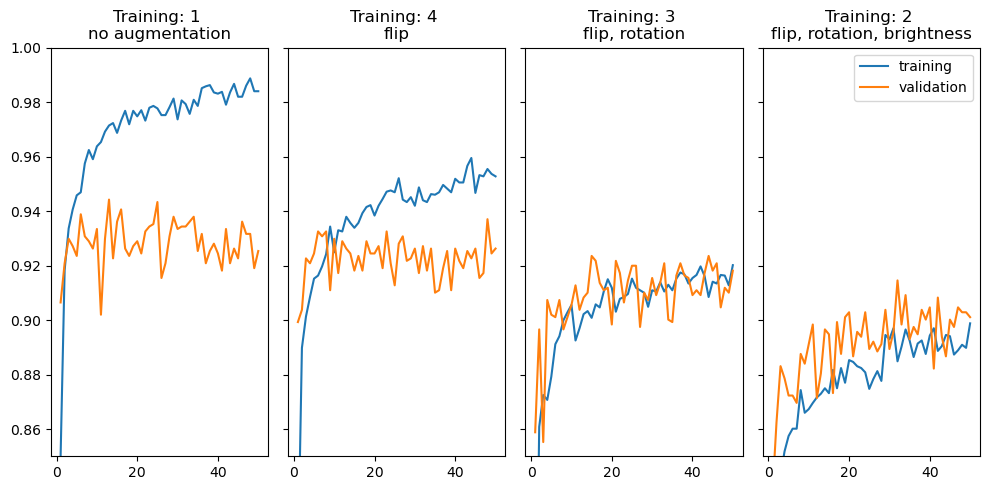

In [16]:
plot_multiple_versions(
    versions=[1, 4, 3, 2],
    titles=['no augmentation', 'flip', 'flip, rotation', 'flip, rotation, brightness'],
    y_lim=(0.85, 1)
)

## Hyperparameter Tuning

### Dropout

Dropout helps reducing overfitting and improving the generalization.
The dropout rate indicates the percentage of nodes of a layer, which are randomly ignored for each training cycle. This introduces noise and should make the model more robust.

Here we are comparing the model performance using three different dropout rates `[0.75, 0.5, 0.25]` and no dropout at all.

In [ ]:
dropouts = [0.75, 0.5, 0.25, 0]

In [ ]:
for dropout in dropouts:

    start = datetime.now()
    print('Start dropout', dropout)

    params_v = copy.deepcopy(base_params)
    params_v['model']['dropout'] = dropout
    del params_v['augmentation']['brightness_range']

    training_id = train_efficientnet_v2_l(df_train_full, epochs=50, params=params_v)

    end = datetime.now()
    print('training id:', training_id)
    print('training time:', (end - start).seconds)

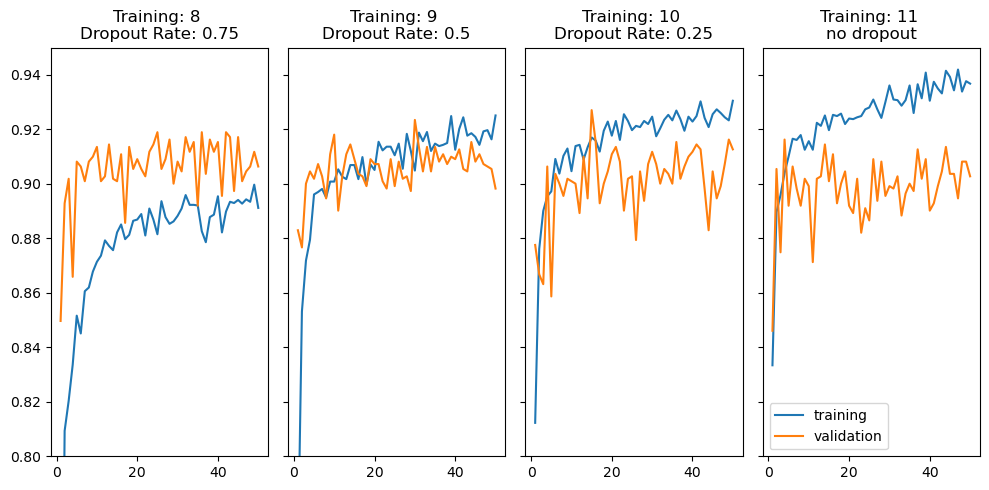

In [17]:
plot_multiple_versions(
    versions=[8, 9, 10, 11], 
    titles=['Dropout Rate: 0.75', 'Dropout Rate: 0.5', 'Dropout Rate: 0.25', 'no dropout'],
    y_lim=(0.8, 0.95),
)

| **Training ID:**             | 8                        | 9            | 10                  | 11                  |
|------------------------------|--------------------------|--------------|---------------------|---------------------|
| **Dropout Rate:**            | 0.75                     | 0.5          | 0.25                | no dropout          |
| **Training Time:**           | 00:43:56                 | 00:43:50     | 00:44:20            | 00:48:00            |
| **Best Epoch:**              | 25                       | 30           | 15                  | 4                   |
| **Training Accuracy:**       | 0.88152                  | 0.904901     | 0.917041            | 0.904002            |
| **Validation Accuracy:**     | 0.918992                 | 0.923492     | 0.927093            | 0.916292            |
| **Notes:**                   | slightly underfitting    |              | slightly overfitting| notably overfitting |


All four models were trained with image augmentation (flip, rotation). 

A high dropout rate leads to underfitting and a low dropout rate or no dropout at all leads to overfittings. Both is confirming the intuition of dropout.

The dropout rate of 0.5 appears to be reasonable and was choosen for further training.

### Learning Rate

The learning rate limits the extend at which backpropagation is changing the weights of the nodes. Higher learning rates might prevent finding a local optimum, because of a too large step size, where as a small learning rate is changing the neural network's weights slower, which increases to training time to reach convergence.

Here we are comparing the model performance using five different learning rates `[0.01, 0.005, 0.001, 0.0005, 0.0001]`.

In [5]:
lrs = [0.01, 0.005, 0.001, 0.0005, 0.0001]

In [ ]:
for lr in lrs:

    start = datetime.now()
    print('Start for lr', lr)

    params_v = copy.deepcopy(base_params)
    params_v['model']['dropout'] = 0.5
    params_v['training']['lr'] = lr
    del params_v['augmentation']['brightness_range']

    training_id = train_efficientnet_v2_l(df_train_full, epochs=50, params=params_v)

    end = datetime.now()
    print('training id:', training_id)
    print('training time:', (end - start).seconds)

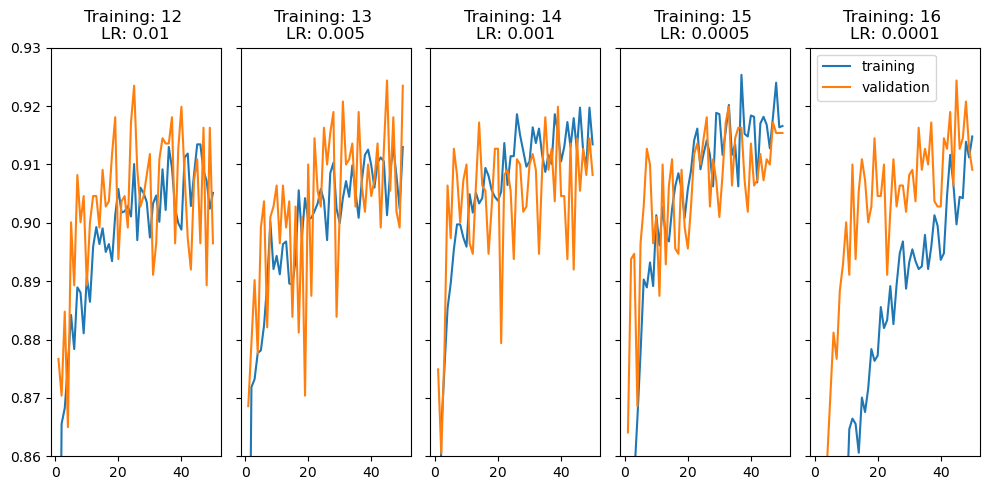

In [20]:
plot_multiple_versions(
    versions=[12,  13, 14, 15, 16], 
    titles=['LR: 0.01', 'LR: 0.005', 'LR: 0.001', 'LR: 0.0005', 'LR: 0.0001'],
    y_lim=(0.86, 0.93),
)

The first two learning rates have the highest variances on the validation score and appear to be somwhat unstable.
Showing all five results in one row makes the plots small. Therefore we will look at the last three with more detail:


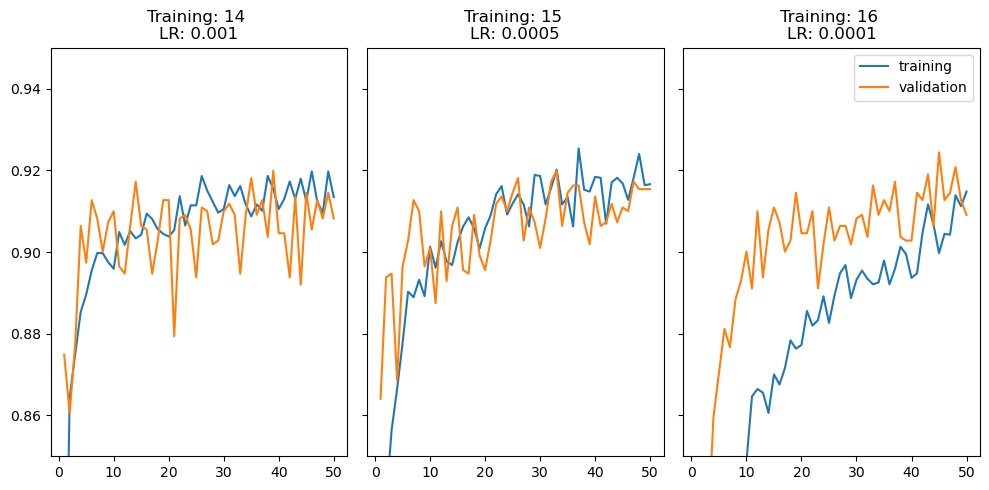

In [21]:
plot_multiple_versions(
    versions=[14, 15, 16], 
    titles=['LR: 0.001', 'LR: 0.0005', 'LR: 0.0001'],
    y_lim=(0.85, 0.95),
)

All choosen learning rates doesn't seem to be overfitting. Which might has to do with the EfficientNetV2 architecture. It is applying BatchNormalization on each convolutional layer, which supports also training with higher learning rates without overfitting.

The training with learning rate of `0.0001` shows signs of underfitting for the first 50 epochs. 

Regardless of the learning rate and training accuracy progression, the validation accuracy seems to be relativly stable. The learning rate of `0.0005` seams to have the best progression on training and validation score and was choosen as final learning rate.


| **Training ID:**             | 12                       | 13           | 14                  | 15                  | 16                  |
|------------------------------|--------------------------|--------------|---------------------|---------------------|---------------------|
| **Learning Rate:**           | 0.01                     | 0.005        | 0.001               | 0.0005              | 0.0001              |
| **Training Time:**           | 00:45:55                 | 00:46:32     | 00:47:56            | 00:48:32            | 00:47:12            |
| **Best Epoch:**              | 25                       | 45           | 39                  | 33                  | 45                  |
| **Training Accuracy:**       | 0.910072                 | 0.901304     | 0.915468            | 0.920189            | 0.89973             |
| **Validation Accuracy:**     | 0.923492                 | 0.924392     | 0.919892            | 0.919892            | 0.924392	           |
| **Kaggle Testdata Accuracy:**| 0.92971                  | 0.92558      | 0.93281             | 0.92868             | 0.92506             |
| **Notes:**                   |                          |              |                     |                     | underfitting        |



## Final Model

After comparing all results, we will choose the following parameters for the final model:
* Image augmentation using horizontal and vertical flips and rotating the image at a maximum of 90 degrees.
* Dropout rate of 0.5
* Learning rate of 0.0005

In [4]:
final_params = {
    'image_size': (150, 150),
    
    'augmentation': {
        'horizontal_flip': True, 
        'vertical_flip': True,
        'rotation_range': 90, 
        'fill_mode': 'nearest',
    },
    
    'model': {
        'pooling': 'max',
        'dense': 64,
        'bn': True,
        'dropout': 0.5
    },

    'training': {
        'lr': 0.0005
    }
    
}

In [5]:
training_id = train_efficientnet_v2_l(df_train_full, epochs=100, params=final_params)

In [6]:
print('Training ID:', training_id)

Training ID: 17


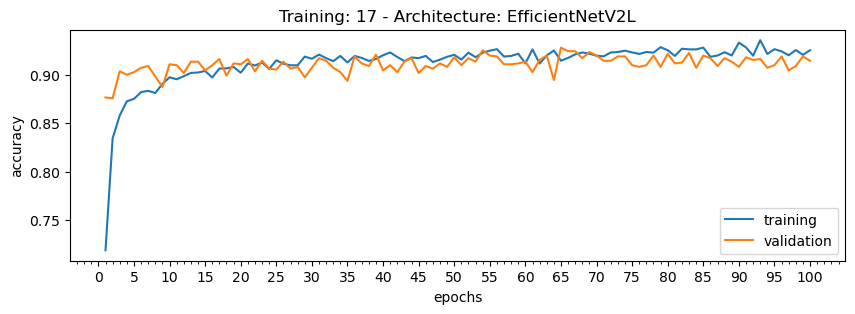

In [7]:
plot_accuracy_for_version(version=17)

## Prediction

If you have not trained the model yourself, you could download the final model here for prediction:

In [ ]:
#!/bin/bash
!fileid="1VjnVxRqKFT2CsDAIVrC7jlVKpPu34rPw"
!filename="model_final.h5"
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=${fileid}" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=${fileid}" -o "models/${filename}"

Import the downloaded model into Keras:

In [2]:
# load best final model
model_best = load_model('models/final_model.h5')
model_params = get_params_for_version(17)
model_labels = get_labels_for_version(17)

Predict based on labeled testdata:

In [3]:
# predict test data
df_test = predict_test_set(model_best, image_size=tuple(model_params.get('image_size')), labels=model_labels, path='data/test_labeled.csv', evaluate=True)

Found 200 validated image filenames.
7/7 [==============================] - 11s 201ms/step
Prediction accuracy: 94.00%.


Print images, where the predicted class (left) does not conform with the actual class (right).

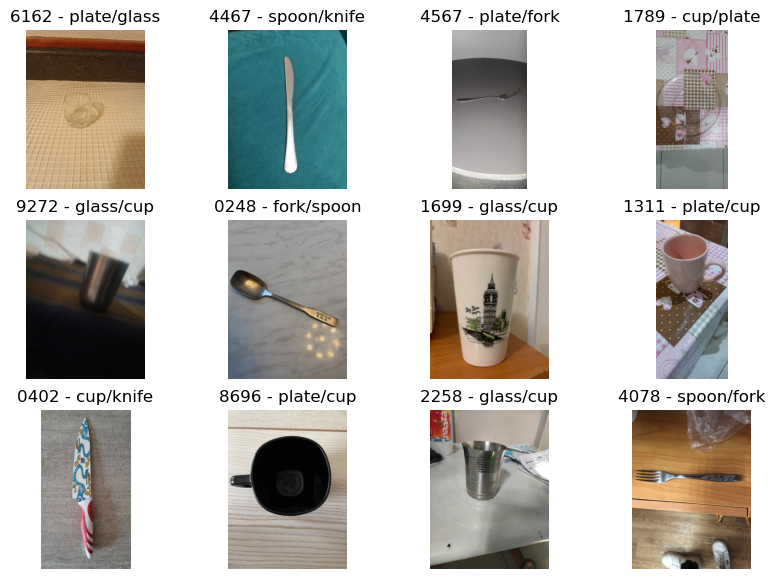

In [4]:
print_false_preds(df_test)

## Submit results
Finally, we need to prepare the submission for Kaggle:

In [6]:
df_test = predict_test_set(model_best, image_size=tuple(model_params.get('image_size')), labels=model_labels, path='data/test.csv', evaluate=False)

Found 3808 validated image filenames.
119/119 [==============================] - 27s 220ms/step


In [7]:
prepare_kaggle_submission(df_test)

Upload the model results to Kaggle:

In [ ]:
!kaggle competitions submit kitchenware-classification -f submission.csv -m 'final_model.h5'